In [16]:
import pandas as pd
import numpy as np
import os 
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)
pd.set_option('display.float_format', '{:,.2f}'.format)

### 1. Obtener datos

In [17]:
df2 = pd.read_csv("C:/Users/nanto.caparachin/Documents/Otros/Oncologia/CARGA_DATASETS_V2.csv", sep=';',encoding='latin1')
df2["FUENTE"] = 'dataset_v2'
df1 = pd.read_csv("C:/Users/nanto.caparachin/Documents/Otros/Oncologia/DATA ATENCIONES ONCOLOGICAS 2022.csv", sep=';', encoding='latin1')
df1["FUENTE"] = 'dataset_2022'
df1.rename(columns={"ï»¿DOCUMENTO_ANONIMIZADO":"DOCUMENTO_ANONIMIZADO"}, inplace=True) # Se debe de aplicar ya que la columna en referencia está viniendo con un nombre incorrecto
df = pd.concat([df1,df2])
del df1, df2

print(f"Se comprueba que la información extraida corresponde a los dos datasets, cada uno de ellos tiene las siguientes fechas de descarga de información: {df.FECHA_CORTE.unique()}")
print(f"Existen registros duplicados. Los cuales son {len(df[df.duplicated()])} registros" if df.duplicated().any() else "No existen registros duplicados.")
df.drop_duplicates(inplace=True)
print(f"Se eliminaron los duplicados: Ahora tenemos un dataset de {len(df)} registros ")

Se comprueba que la información extraida corresponde a los dos datasets, cada uno de ellos tiene las siguientes fechas de descarga de información: [20230525 20231113]
Existen registros duplicados. Los cuales son 740 registros
Se eliminaron los duplicados: Ahora tenemos un dataset de 819935 registros 


### 2. Limpieza de datos

In [18]:
# Para eliminar caracteres extraños en las IPRESS
df["IPRESS"] = df["IPRESS"].str.replace(r'â\x80\x93|\x96', '-', regex=True)
df["IPRESS"] = df["IPRESS"].str.replace(r'NIÃ\x91O', 'NIÑO', regex=True)

reemplazos = {'AREQUIPA ':'AREQUIPA',
                'AYACUCHO ': 'AYACUCHO',
                'CAJAMARCA ':'CAJAMARCA',
                'CUSCO ': 'CUSCO',
                'HUANCAVELICA ': 'HUANCAVELICA',
                'HUANUCO ': 'HUANUCO',
                'ICA ':'ICA',
                'LA LIBERTAD ':'LA LIBERTAD',
                'R. LA LIBERTAD ':'LA LIBERTAD',
                'LAMBAYEQUE ': 'LAMBAYEQUE',
                'LORETO ':'LORETO',
                'PIURA ': 'PIURA',
                'REGION CALLAO ':'CALLAO',
                'REGION LIMA ':'LIMA'}

df['REGION'] = df['REGION'].replace(reemplazos)

In [19]:
# Cambiar el tipo de datos a fechas
df["FECHA_ATENCION"] = pd.to_datetime(df["FECHA_ATENCION"], format='%Y%m%d')
df["FECHA_ALTA"] = pd.to_datetime(df["FECHA_ALTA"], format='%Y%m%d')
df["FECHA_INTERNAMIENTO"] = pd.to_datetime(df["FECHA_INTERNAMIENTO"], format='%Y%m%d')
df["FECHA_CORTE"] = pd.to_datetime(df["FECHA_CORTE"], format='%Y%m%d')

### 3. Agregación de columnas

In [20]:
# Se asume que: Al corte de la obtención de la data aquellos pacientes que no tienen fecha de alta aún continuan hospitalizados
Estado_paciente = []
for index, row in df.iterrows():
    if pd.isna(row['FECHA_INTERNAMIENTO']):
        Estado_paciente.append(np.nan)
    else:
        if pd.isna(row['FECHA_ALTA']):
            Estado_paciente.append('En_Tratamiento')
        else:
            Estado_paciente.append('Con_AltaMedica')
df["ESTADO_PACIENTE"] = Estado_paciente

In [21]:
# Se crea una columna para calcular el tiempo promedio de internamiento
df['TIEMPO_INTERNAMIENTO'] = np.where(df["ESTADO_PACIENTE"] == 'Con_AltaMedica', (df['FECHA_ALTA'] - df['FECHA_INTERNAMIENTO']).dt.days,
                                        np.where(
                                            df["ESTADO_PACIENTE"] == 'En_Tratamiento',
                                            (df['FECHA_CORTE'] - df['FECHA_INTERNAMIENTO']).dt.days,
                                            np.nan
                                        )
                                    )

In [22]:
# Se asume que: Una hospitalización de un paciente oncológico no se realice para un solo día, entonces podemos utilizar esa lógica para deducir el tipo de internamiento
df["TIPO_INTERNAMIENTO"] = df['TIEMPO_INTERNAMIENTO'].apply(
                                            lambda x: "Hospitalizacion" if x > 1 
                                                else "Emergencia/Cx_día" if x == 1 
                                                else x
                                        )

In [23]:
# Se agrega una columna para identificar la primera fecha de atención vs la última fecha de atención por paciente, así como el tiempo entre estas atenciones
df_paciente = df.groupby(['DOCUMENTO_ANONIMIZADO']).agg(
                        FECHA_MINIMA_ATENCION = ('FECHA_ATENCION', 'min'),
                        FECHA_MAXIMA_ATENCION = ('FECHA_ATENCION', 'max')
                    ).reset_index()

df_paciente['FECHA_MINIMA_ATENCION'] = pd.to_datetime(df_paciente['FECHA_MINIMA_ATENCION'], format='%Y-%m-%d')
df_paciente['FECHA_MAXIMA_ATENCION'] = pd.to_datetime(df_paciente['FECHA_MAXIMA_ATENCION'], format='%Y-%m-%d')

df_paciente["RANGO_ATENCION"] = (df_paciente['FECHA_MAXIMA_ATENCION'] - df_paciente['FECHA_MINIMA_ATENCION']).dt.days

### 4. Exploración de los datos

In [24]:
print("A continuación se identifica los registros vacios:")
df.isnull().sum()

A continuación se identifica los registros vacios:


DOCUMENTO_ANONIMIZADO         0
PERIODO                       0
RENAES                        0
IPRESS                      144
REGION                        0
DEPARTAMENTO              16033
PROVINCIA                 16033
DISTRITO                  16033
UBIGEO                    24882
CODIGO_DIAGNOSTICO            0
DIAGNOSTICOS                  0
GRUPO_DIAGNOSTICOS            0
GRUPO_COBERTURA               0
SEXO                          0
EDAD                          0
TIPO_SEGURO                   0
CODIGO_SERVICIO               0
SERVICIO                      0
FECHA_ATENCION                0
FECHA_INTERNAMIENTO      747229
FECHA_ALTA               658541
MONTO_BRUTO                   0
FECHA_CORTE                   0
FUENTE                        0
ESTADO_PACIENTE          747229
TIEMPO_INTERNAMIENTO     747229
TIPO_INTERNAMIENTO       747229
dtype: int64

In [25]:
print(f'Se observa que hay {len(df["RENAES"].unique())} hospitales, de {len(df["REGION"].unique())}')

Se observa que hay 75 hospitales, de 24


In [26]:
print(f"La data que se ha disponibilizado en la fuente de datos abiertos tiene información de pacientes desde el {df['FECHA_ATENCION'].dt.date.min()} hasta el {df['FECHA_ATENCION'].dt.date.max()}")

La data que se ha disponibilizado en la fuente de datos abiertos tiene información de pacientes desde el 2021-07-14 hasta el 2023-06-30


In [54]:
cant_pacientes_data = len(df.DOCUMENTO_ANONIMIZADO.unique())
print(f"Número de pacientes que se encuentran en el dataset: {cant_pacientes_data}")

globocan_casos_peru = 175090 # fuente: https://gco.iarc.fr/today/data/factsheets/populations/604-peru-fact-sheets.pdf
df_unicos_personas_ipress = df[["DOCUMENTO_ANONIMIZADO", "RENAES"]].drop_duplicates()
agrupado_unicos_personas_ipress = df_unicos_personas_ipress.groupby("DOCUMENTO_ANONIMIZADO").count().reset_index()
pacientes_entre_establecimientos = len(agrupado_unicos_personas_ipress[agrupado_unicos_personas_ipress["RENAES"]>1])

print(f"el número de pacientes que se han movido entre establecimientos de salud es de {pacientes_entre_establecimientos}")

print(f"Según globocan en el Perú hay una prevalencia de {globocan_casos_peru} pacientes con cáncer, sin embargo en la data solo existe {int(cant_pacientes_data)}, lo que significa que solo tenemos {round((cant_pacientes_data*100/globocan_casos_peru),2)}% de los pacientes del país")

Número de pacientes que se encuentran en el dataset: 40548
el número de pacientes que se han movido entre establecimientos de salud es de 19054
Según globocan en el Perú hay una prevalencia de 175090 pacientes con cáncer, sin embargo en la data solo existe 40548, lo que significa que solo tenemos 23.16% de los pacientes del país


In [65]:
print("Tabla 2: A continuación se indica el número de registros por establecimiento, considerando el top 20 de IPRESS")
df[["DEPARTAMENTO","RENAES","IPRESS"]].value_counts().reset_index(name='Cantidad de registros').head(20)

Tabla 2: A continuación se indica el número de registros por establecimiento, considerando el top 20 de IPRESS


,DEPARTAMENTO,RENAES,IPRESS,Cantidad de registros
0,Lima,6210,INSTITUTO NACIONAL DE ENFERMEDADES NEOPLASICAS - INEN,501421
1,La Libertad,7277,INSTITUTO REGIONAL DE ENFERMEDADES NEOPLASICAS - LUIS PINILLOS GANOZA - IREN,87155
2,Lambayeque,11470,HOSPITAL REGIONAL DE LAMBAYEQUE,26619
3,Arequipa,7397,INSTITUTO REGIONAL DE ENFERMEDADES NEOPLASICAS,24895
4,Lima,7633,HOSPITAL NACIONAL CAYETANO HEREDIA,21041
5,Lima,16918,INSTITUTO NACIONAL DE SALUD DEL NIÑO - SAN BORJA,16380
6,Lima,5987,HOSPITAL MARIA AUXILIADORA,15243
7,Lima,6206,HOSPITAL NACIONAL DOS DE MAYO,10514
8,Callao,6218,NAC. DANIEL A. CARRION,9509
9,Lima,6211,HOSPITAL DE APOYO SANTA ROSA,9422


In [57]:
print(f"El INEN, registra 501,421 atenciones que representa el {round((501421*100/len(df)),2)}% de las atenciones totales.")

El INEN, registra 501,421 atenciones que representa el 61.15% de las atenciones totales.


In [30]:
print(f"Número de pacientes que se encuentran en el dataset: {len(df.DOCUMENTO_ANONIMIZADO.unique())}")

df_unicos_personas_grupodiagnostico = df[["DOCUMENTO_ANONIMIZADO", "GRUPO_DIAGNOSTICOS"]].drop_duplicates()
agrupado_unicos_personas_grupodiagnostico = df_unicos_personas_grupodiagnostico.groupby("DOCUMENTO_ANONIMIZADO").count().reset_index()
pacientes_entre_grupodiagnostico = len(agrupado_unicos_personas_grupodiagnostico[agrupado_unicos_personas_grupodiagnostico["GRUPO_DIAGNOSTICOS"]>1])

print(f"El número de pacientes que tienen más de un grupo de diagnóstico es: {pacientes_entre_grupodiagnostico}, los cuales pueden ser catalogados como complejos")

Número de pacientes que se encuentran en el dataset: 40548
El número de pacientes que tienen más de un grupo de diagnóstico es: 16041, los cuales pueden ser catalogados como complejos


In [31]:
print(f"Número de pacientes que se encuentran en el dataset: {len(df.DOCUMENTO_ANONIMIZADO.unique())}")

df["INTERNAMIENTO"] = df['FECHA_INTERNAMIENTO'].notna().astype(int)
df_unicos_internamiento_pacientes_si_no = df[['DOCUMENTO_ANONIMIZADO','INTERNAMIENTO']].drop_duplicates()
df_unicos_internamiento_pacientes = df_unicos_internamiento_pacientes_si_no.groupby('DOCUMENTO_ANONIMIZADO')['INTERNAMIENTO'].max().reset_index()

print(f"La cantidad de pacientes internado es de {len(df_unicos_internamiento_pacientes[df_unicos_internamiento_pacientes['INTERNAMIENTO'] == 1])}, los cuales pueden ser catalogados como complejos ")

Número de pacientes que se encuentran en el dataset: 40548
La cantidad de pacientes internado es de 18528, los cuales pueden ser catalogados como complejos 


In [32]:
print("A continuación se muestra como están organizados los diagnósticos, tomando como referencia 25 tipos como ejemplo")
df[["GRUPO_DIAGNOSTICOS","CODIGO_DIAGNOSTICO","DIAGNOSTICOS"]].drop_duplicates().sort_values('CODIGO_DIAGNOSTICO').head(25)

A continuación se muestra como están organizados los diagnósticos, tomando como referencia 25 tipos como ejemplo


,GRUPO_DIAGNOSTICOS,CODIGO_DIAGNOSTICO,DIAGNOSTICOS
656,CANCER DE ESTOMAGO,C160,TUMOR MALIGNO DEL CARDIAS
13,CANCER DE ESTOMAGO,C161,TUMOR MALIGNO DEL FUNDUS GASTRICO
171,CANCER DE ESTOMAGO,C162,TUMOR MALIGNO DEL CUERPO DEL ESTOMAGO
17,CANCER DE ESTOMAGO,C163,TUMOR MALIGNO DEL ANTRO PILORICO
1270,CANCER DE ESTOMAGO,C164,TUMOR MALIGNO DEL PILORO
12138,CANCER DE ESTOMAGO,C165,TUMOR MALIGNO DE LA CURVATURA MENOR DEL ESTOMA...
29666,CANCER DE ESTOMAGO,C166,TUMOR MALIGNO DE LA CURVATURA MAYOR DEL ESTOMA...
1390,CANCER DE ESTOMAGO,C168,LESION DE SITIOS CONTIGUOS DEL ESTOMAGO
2,CANCER DE ESTOMAGO,C169,"TUMOR MALIGNO DEL ESTOMAGO, PARTE NO ESPECIFICADA"
97,CANCER DE COLON,C180,TUMOR MALIGNO DEL CIEGO


### 5. Cantidad de Atenciones por paciente

In [33]:
# Se crea un dataset que indica el número de documento y el número de atenciones por paciente
df_pacientes_atenciones = df.groupby(['DOCUMENTO_ANONIMIZADO'])["FECHA_ATENCION"].count().reset_index(name='Cant_atenciones').sort_values(['Cant_atenciones'],ascending=False) 

print(f"A continuación se muestra la cantidad de atenciones, por paciente así como su distribución")
df_pacientes_atenciones.describe()[['Cant_atenciones']]

A continuación se muestra la cantidad de atenciones, por paciente así como su distribución


,Cant_atenciones
count,"40,548.00"
mean,20.22
std,25.88
min,1.00
25%,2.00
50%,9.00
75%,28.00
max,300.00


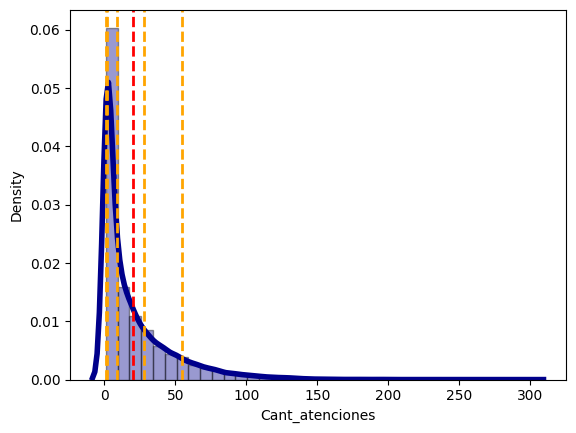

In [34]:
datos = df_pacientes_atenciones['Cant_atenciones']

# Calculando percentiles y promedio
percentil_10 = np.percentile(datos, 10)
percentil_25 = np.percentile(datos, 25)
percentil_50 = np.percentile(datos, 50)
percentil_75 = np.percentile(datos, 75)
percentil_90 = np.percentile(datos, 90)
promedio = np.mean(datos)

# Crear el histograma
sns.distplot(datos, hist=True, kde=True, bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})

# Añadir las líneas de los percentiles y el promedio
plt.axvline(percentil_10, color='orange', linestyle='dashed', linewidth=2)
plt.axvline(percentil_25, color='orange', linestyle='dashed', linewidth=2)
plt.axvline(percentil_50, color='orange', linestyle='dashed', linewidth=2)
plt.axvline(percentil_75, color='orange', linestyle='dashed', linewidth=2)
plt.axvline(percentil_90, color='orange', linestyle='dashed', linewidth=2)
plt.axvline(promedio, color='red', linestyle='dashed', linewidth=2)

plt.show()

### 5. Tiempo de Internamiento (En hospitalización)

In [64]:
# Crear columna con los dias de internamiento
df_hospitalizacion = df[(df["INTERNAMIENTO"] == 1) & (df["TIPO_INTERNAMIENTO"] == 'Hospitalizacion')]

print('Tabla 1: Tiempo de internamiento en días')
df_hospitalizacion[['TIEMPO_INTERNAMIENTO']].describe()

Tabla 1: Tiempo de internamiento en días


,TIEMPO_INTERNAMIENTO
count,"18,706.00"
mean,11.74
std,16.56
min,2.00
25%,3.00
50%,6.00
75%,14.00
max,376.00


In [36]:
df_hospitalizacion['TIEMPO_INTERNAMIENTO'].quantile(0.90)

28.0

### 6. Grupo de Diagnóstico - Costo Promedio

In [37]:
print("Metodología: Se ha utilizado como referencia para cada paciente el último diagnóstico con el que ha sido atendido, \n\
            de manera que el costo acumulado de cada paciente se asigne a un solo diagnóstico.\n\
            En caso se hubiera tenido identificado el diagnóstico primario del paciente, hubiera sido utilizado en lugar de este")      

Metodología: Se ha utilizado como referencia para cada paciente el último diagnóstico con el que ha sido atendido, 
            de manera que el costo acumulado de cada paciente se asigne a un solo diagnóstico.
            En caso se hubiera tenido identificado el diagnóstico primario del paciente, hubiera sido utilizado en lugar de este


In [38]:
# Fecha de atencion máxima de cada paciente
df_paciente_fechaatencion = df[['DOCUMENTO_ANONIMIZADO','FECHA_ATENCION']].drop_duplicates()
df_paciente_fechaatencion_maxima = df_paciente_fechaatencion.groupby('DOCUMENTO_ANONIMIZADO')['FECHA_ATENCION'].max().reset_index()

# Diagnostico de atención, según fecha de atención máxima: 
df_paciente_diagnostico_fechaatencion = df[['DOCUMENTO_ANONIMIZADO','FECHA_ATENCION','GRUPO_DIAGNOSTICOS']].drop_duplicates()

# Identificar diagnóstico para cada paciente: 
df_paciente_ultimo_diagnostico = pd.merge(df_paciente_fechaatencion_maxima, df_paciente_diagnostico_fechaatencion, on=['DOCUMENTO_ANONIMIZADO','FECHA_ATENCION'], how='inner')
df_paciente_ultimo_diagnostico.head()

,DOCUMENTO_ANONIMIZADO,FECHA_ATENCION,GRUPO_DIAGNOSTICOS
0,0,2022-02-28,CANCER DE PROSTATA
1,4,2022-10-28,CANCER DE CUELLO UTERINO
2,11,2023-03-06,LEUCEMIA
3,13,2022-05-11,CANCER DE MAMA
4,14,2022-06-23,CANCER DE MAMA


In [39]:
# Hallar el costo de tratamiento para cada paciente
df_costo_paciente_diagnostico_bruto = df[["DOCUMENTO_ANONIMIZADO","GRUPO_DIAGNOSTICOS","MONTO_BRUTO"]]
df_costo_paciente_diagnostico_tratamiento = df_costo_paciente_diagnostico_bruto.groupby(["DOCUMENTO_ANONIMIZADO"])['MONTO_BRUTO'].sum().reset_index(name='MONTO_TRATAMIENTO')

# Relacionar el último diagnostico al MONTO_TRATAMIENTO obtenigo para cada paciente 
df_costo_tratamiento_paciente = pd.merge(df_costo_paciente_diagnostico_tratamiento,df_paciente_ultimo_diagnostico, on='DOCUMENTO_ANONIMIZADO', how='inner')
df_costo_tratamiento_paciente

,DOCUMENTO_ANONIMIZADO,MONTO_TRATAMIENTO,FECHA_ATENCION,GRUPO_DIAGNOSTICOS
0,0,70.34,2022-02-28,CANCER DE PROSTATA
1,4,"1,401.85",2022-10-28,CANCER DE CUELLO UTERINO
2,11,112.42,2023-03-06,LEUCEMIA
3,13,612.46,2022-05-11,CANCER DE MAMA
4,14,392.63,2022-06-23,CANCER DE MAMA
...,...,...,...,...
40679,997220,"9,483.02",2023-06-03,CANCER DE CUELLO UTERINO
40680,997800,"3,519.00",2023-05-18,LINFOMA
40681,999060,40.66,2023-05-09,LEUCEMIA
40682,999400,"17,004.99",2023-05-06,LINFOMA


In [67]:
df_costo_tratamiento_paciente_agrupado = df_costo_tratamiento_paciente.groupby('GRUPO_DIAGNOSTICOS').agg(
                                                                        COSTO_PROMEDIO=('MONTO_TRATAMIENTO', 'mean'), 
                                                                        COSTO_P20= ('MONTO_TRATAMIENTO', lambda x: x.quantile(0.2)),
                                                                        COSTO_P50=('MONTO_TRATAMIENTO', 'median'), 
                                                                        COSTO_P80= ('MONTO_TRATAMIENTO', lambda x: x.quantile(0.8)),
                                                                        PACIENTES_ATENDIDOS=('DOCUMENTO_ANONIMIZADO', 'count') 
                                                                    ).reset_index()

df_costo_tratamiento_paciente_agrupado

,GRUPO_DIAGNOSTICOS,COSTO_PROMEDIO,COSTO_P20,COSTO_P50,COSTO_P80,PACIENTES_ATENDIDOS
0,CANCER DE COLON,"4,126.76",99.31,"1,005.45","6,060.49",3514
1,CANCER DE CUELLO UTERINO,"2,800.16",16.61,477.31,"3,957.23",9859
2,CANCER DE ESTOMAGO,"3,633.46",101.14,"1,027.24","4,786.60",3563
3,CANCER DE MAMA,"4,196.19",94.75,"1,425.07","6,128.20",11909
4,CANCER DE PROSTATA,"2,949.57",116.51,"1,175.68","4,570.79",3877
5,LEUCEMIA,"16,799.25",163.71,"2,026.73","25,775.03",4142
6,LINFOMA,"5,568.80",163.95,"1,724.36","6,878.97",3820


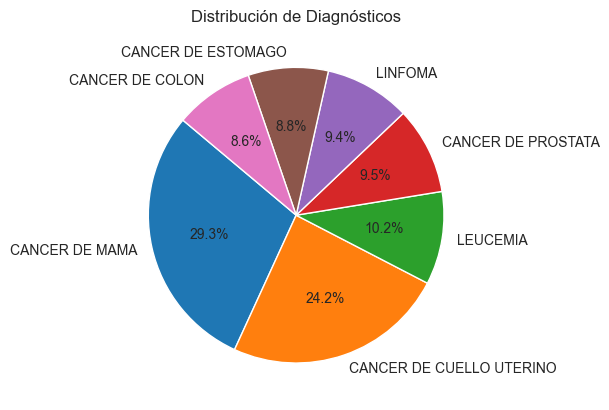

In [70]:
df_costo_tratamiento_paciente_agrupado['PORCENTAJE'] = df_costo_tratamiento_paciente_agrupado['PACIENTES_ATENDIDOS'] / df_costo_tratamiento_paciente_agrupado['PACIENTES_ATENDIDOS'].sum() * 100

# Ordenar los datos de mayor a menor
df_ordenado = df_costo_tratamiento_paciente_agrupado.sort_values('PORCENTAJE', ascending=False)

# Crear el gráfico de tipo pie
plt.pie(df_ordenado['PACIENTES_ATENDIDOS'], labels=df_ordenado['GRUPO_DIAGNOSTICOS'], autopct='%1.1f%%', startangle=140)

plt.title('Distribución de Diagnósticos')
plt.show()

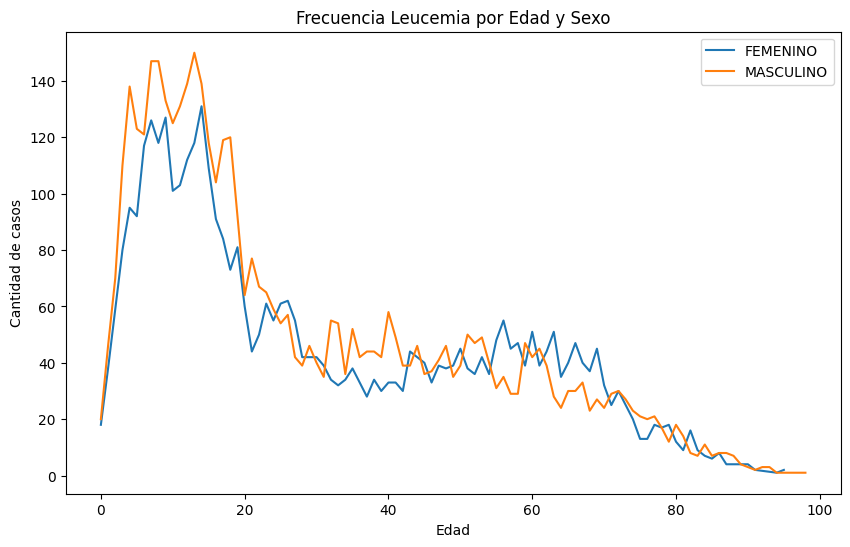

In [41]:
df_pacientes_leucemia = df[df['GRUPO_DIAGNOSTICOS'] == 'LEUCEMIA'][['DOCUMENTO_ANONIMIZADO','EDAD','SEXO']].drop_duplicates()
df_pacientes_leucemia_edad_sexo = df_pacientes_leucemia.groupby(['SEXO','EDAD']).agg(CANT_PAC_LEUCEMIA = ('DOCUMENTO_ANONIMIZADO','count')).reset_index()

plt.figure(figsize=(10, 6))

for sexo in df_pacientes_leucemia_edad_sexo['SEXO'].unique():
    data_filtrada = df_pacientes_leucemia_edad_sexo[df_pacientes_leucemia_edad_sexo['SEXO'] == sexo]
    plt.plot(data_filtrada['EDAD'], data_filtrada['CANT_PAC_LEUCEMIA'], label=sexo)

plt.xlabel('Edad')
plt.ylabel('Cantidad de casos')
plt.title('Frecuencia Leucemia por Edad y Sexo')
plt.legend()

plt.show()

### 7. Cuantos fueron de Provincia a Lima, y Cuantos regresaron a Provincia a continuar con su tratamiento

In [42]:
# Crea un dataset donde 
df_pacientes_region_atencion = df[['DOCUMENTO_ANONIMIZADO','REGION','FECHA_ATENCION']].drop_duplicates().sort_values(['DOCUMENTO_ANONIMIZADO','FECHA_ATENCION'])
df_pacientes_region_atencion['auxiliar'] = (df_pacientes_region_atencion['DOCUMENTO_ANONIMIZADO'] != df_pacientes_region_atencion['DOCUMENTO_ANONIMIZADO'].shift()) | (df_pacientes_region_atencion['REGION'] != df_pacientes_region_atencion['REGION'].shift())
df_pacientes_region_atencion['ORDEN_VIAJES'] = df_pacientes_region_atencion.groupby('DOCUMENTO_ANONIMIZADO')['auxiliar'].cumsum()
df_pacientes_region_atencion.drop('auxiliar', axis=1, inplace=True)

In [43]:
# Crea un dataset, solo con los registros únicos de viajes entre Regiones
df_paciente_orden = df_pacientes_region_atencion[['DOCUMENTO_ANONIMIZADO', 'REGION','ORDEN_VIAJES']].drop_duplicates()

# Contamos la cantidad de viajes entre los diferentes regiones de cada paciente
df_viajes_paciente = df_paciente_orden.groupby(["DOCUMENTO_ANONIMIZADO"]).agg(
                                                                                CANTIDAD_VIAJES = ('ORDEN_VIAJES','count')
                                                                            ).reset_index()
# Análizamos cuanto fue el promedio de viajes por paciente de aquellos que se movieron entre regiones
df_viajes_paciente_masde_1 = df_viajes_paciente[df_viajes_paciente["CANTIDAD_VIAJES"]>1]
df_viajes_paciente_masde_1.describe()[["CANTIDAD_VIAJES"]]

,CANTIDAD_VIAJES
count,"13,427.00"
mean,5.89
std,7.41
min,2.00
25%,2.00
50%,3.00
75%,6.00
max,89.00


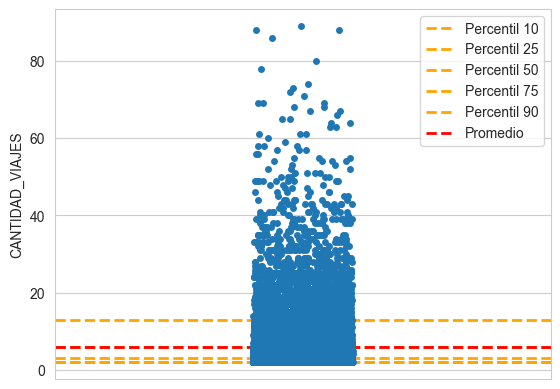

In [44]:
# Configurar el estilo del gráfico
sns.set_style('whitegrid')

# Supongo que df_viajes_paciente_masde_1['CANTIDAD_VIAJES'] es tu conjunto de datos
datos = df_viajes_paciente_masde_1['CANTIDAD_VIAJES']
percentil_10 = np.percentile(datos, 10)
percentil_25 = np.percentile(datos, 25)
percentil_50 = np.percentile(datos, 50)
percentil_75 = np.percentile(datos, 75)
percentil_90 = np.percentile(datos, 90)
promedio = np.mean(datos)

# Crear el stripplot
ax = sns.stripplot(y="CANTIDAD_VIAJES", data=df_viajes_paciente_masde_1)
ax.axhline(percentil_10, color='orange', linestyle='dashed', linewidth=2, label='Percentil 10')
ax.axhline(percentil_25, color='orange', linestyle='dashed', linewidth=2, label='Percentil 25')
ax.axhline(percentil_50, color='orange', linestyle='dashed', linewidth=2, label='Percentil 50')
ax.axhline(percentil_75, color='orange', linestyle='dashed', linewidth=2, label='Percentil 75')
ax.axhline(percentil_90, color='orange', linestyle='dashed', linewidth=2, label='Percentil 90')
ax.axhline(promedio, color='red', linestyle='dashed', linewidth=2, label='Promedio')

ax.legend()
plt.show()

7.1. Se ha identificado una posible oportunidad de mejora / Riesgo en la atención de los pacientes. Debido al alta cantidad de viajes para continuar tratamiento

In [45]:
df_pacientes = pd.merge(df_paciente,df_viajes_paciente_masde_1,on='DOCUMENTO_ANONIMIZADO' ,how='inner')
df_pacientes['ratio_viajes_dias_atencion'] = round((df_pacientes['RANGO_ATENCION']/df_pacientes['CANTIDAD_VIAJES']),3)
df_pacientes[(df_pacientes['ratio_viajes_dias_atencion']<20) & (df_pacientes['CANTIDAD_VIAJES']>6)].sort_values('CANTIDAD_VIAJES',ascending=False)

,DOCUMENTO_ANONIMIZADO,FECHA_MINIMA_ATENCION,FECHA_MAXIMA_ATENCION,RANGO_ATENCION,CANTIDAD_VIAJES,ratio_viajes_dias_atencion
3146,22474,2021-12-14,2023-06-13,546,89,6.13
6731,48871,2021-11-16,2023-06-06,567,88,6.44
400,2671,2021-12-01,2023-06-09,555,88,6.31
10922,80181,2021-11-15,2023-06-02,564,86,6.56
8519,61864,2021-12-29,2023-06-05,523,80,6.54
...,...,...,...,...,...,...
2776,19934,2022-02-03,2022-05-11,97,7,13.86
9228,67064,2022-11-07,2023-03-24,137,7,19.57
4628,33232,2021-11-12,2022-02-25,105,7,15.00
856,5831,2023-04-11,2023-06-08,58,7,8.29


In [63]:
df_pacientes[(df_pacientes['ratio_viajes_dias_atencion']<20) & (df_pacientes['CANTIDAD_VIAJES']>6)].sort_values('CANTIDAD_VIAJES',ascending=False).to_excel('casos_oportunidad_meojora.xlsx',index=False)

### Registros que serán anécdota:

In [50]:
validacion_mismopaciente_documento_anonimizado = df[['DOCUMENTO_ANONIMIZADO','SEXO','EDAD']].drop_duplicates().sort_values('EDAD')

pacientes_ok = []
pacientes_sospechosos = []
for id, agrupacion in validacion_mismopaciente_documento_anonimizado.groupby('DOCUMENTO_ANONIMIZADO'):
    comprobacion_sexo = list(agrupacion.SEXO.unique())
    
    bucle = 0
    for _,registro in agrupacion.iterrows():
        
        if bucle == 0:
            edad1 = registro['EDAD']
        
        if bucle == 1:
            edad2 = registro['EDAD'] 

            if edad1 + 1 == edad2 and len(comprobacion_sexo) == 1:
                pacientes_ok.append(id)
            else: 
                print(f'Paciente con DOCUMENTO_ANONIMIZADO: {id}, tiene inconsistencia en SEXO {comprobacion_sexo} o EDAD: {edad1} - {edad2}')
                pacientes_sospechosos.append(id)

        bucle += 1

print(f"\n\n =================================================================================================================")
print(f"Existen {len(pacientes_ok)} pacientes que si mantienen una lógica correcta de edad, sexo, y {len(pacientes_sospechosos)} que no tienen una lógica correcta")

Paciente con DOCUMENTO_ANONIMIZADO: 20, tiene inconsistencia en SEXO ['FEMENINO'] o EDAD: 45 - 70
Paciente con DOCUMENTO_ANONIMIZADO: 22, tiene inconsistencia en SEXO ['FEMENINO', 'MASCULINO'] o EDAD: 50 - 74
Paciente con DOCUMENTO_ANONIMIZADO: 24, tiene inconsistencia en SEXO ['FEMENINO'] o EDAD: 36 - 40
Paciente con DOCUMENTO_ANONIMIZADO: 31, tiene inconsistencia en SEXO ['FEMENINO', 'MASCULINO'] o EDAD: 60 - 61
Paciente con DOCUMENTO_ANONIMIZADO: 42, tiene inconsistencia en SEXO ['FEMENINO', 'MASCULINO'] o EDAD: 45 - 46
Paciente con DOCUMENTO_ANONIMIZADO: 50, tiene inconsistencia en SEXO ['MASCULINO'] o EDAD: 66 - 80
Paciente con DOCUMENTO_ANONIMIZADO: 51, tiene inconsistencia en SEXO ['FEMENINO', 'MASCULINO'] o EDAD: 62 - 63
Paciente con DOCUMENTO_ANONIMIZADO: 60, tiene inconsistencia en SEXO ['FEMENINO', 'MASCULINO'] o EDAD: 51 - 54
Paciente con DOCUMENTO_ANONIMIZADO: 80, tiene inconsistencia en SEXO ['FEMENINO', 'MASCULINO'] o EDAD: 70 - 87
Paciente con DOCUMENTO_ANONIMIZADO: 84,

In [52]:
consulta = df[df['DOCUMENTO_ANONIMIZADO'].isin(pacientes_sospechosos[:30])].sort_values(['DOCUMENTO_ANONIMIZADO'])[['DOCUMENTO_ANONIMIZADO','IPRESS', 'REGION',
                                                                                                                    'DEPARTAMENTO', 'DISTRITO', 'CODIGO_DIAGNOSTICO',
                                                                                                                    'DIAGNOSTICOS', 'GRUPO_DIAGNOSTICOS', 'SEXO', 'EDAD',
                                                                                                                    'FECHA_ATENCION', 'MONTO_BRUTO', 
                                                                                                                    'FUENTE']]

consulta_ = consulta.groupby(['DOCUMENTO_ANONIMIZADO'])

for _, grupo in consulta_:
    print(_)
    print(grupo.to_string())
    print("-----------------------------------------------------\n")

(20,)
       DOCUMENTO_ANONIMIZADO                                                IPRESS      REGION DEPARTAMENTO  DISTRITO CODIGO_DIAGNOSTICO                                                 DIAGNOSTICOS        GRUPO_DIAGNOSTICOS      SEXO  EDAD FECHA_ATENCION  MONTO_BRUTO      FUENTE
51799                     20                    HOSPITAL NACIONAL ARZOBISPO LOAYZA        LIMA         Lima      Lima               C509              TUMOR MALIGNO DE LA MAMA, PARTE NO ESPECIFICADA            CANCER DE MAMA  FEMENINO    70     2022-12-17        15.55  dataset_v2
51686                     20  HOSPITAL DE LA AMISTAD PERU - COREA SANTA ROSA II-2        PIURA        Piura     Piura               C539  TUMOR MALIGNO DEL CUELLO DEL UTERO, SIN OTRA ESPECIFICACION  CANCER DE CUELLO UTERINO  FEMENINO    86     2023-02-11     1,119.49  dataset_v2
51704                     20                                     HOSPITAL TARAPOTO  SAN MARTIN   San Martin  Tarapoto               C509              TUMO